In [3]:
## Import needed libraries
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import pylab   as plt

In [4]:
# hSBM specific libraries
from sbmtm import sbmtm
import graph_tool.all as gt

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [6]:
file = open('hSBM_simple_model.pickle', 'rb')
model = pickle.load(file)

In [7]:
# The hierarchical levels themselves are represented by individual BlockState() instances
levels = model.state.get_levels()
for s in levels:
    print(s)
    if s.get_N() == 1:
        break

<BlockState object with 38423 blocks (2 nonempty), degree-corrected, for graph <Graph object, undirected, with 38423 vertices and 46181 edges, 2 internal vertex properties, at 0x7f326051ba30>, at 0x7f323d59b1f0>
<BlockState object with 2 blocks (1 nonempty), for graph <Graph object, undirected, with 38423 vertices and 1 edge, at 0x7f323d59bf70>, at 0x7f323ce2d130>


In [8]:
nest_state = model.state
lstate = nest_state.get_levels()[0]
adj_matrix = gt.adjacency(g=lstate.get_bg(),weight=lstate.get_ers()).T
synth_graph = gt.generate_sbm(b=lstate.b.a, probs=adj_matrix, 
                            out_degs=lstate.g.degree_property_map("total").a,
                            in_degs=lstate.g.degree_property_map("total").a,
                            directed=False)
synth_nest_state = model.state.copy(g=synth_graph)

In [9]:
synth_file = open('synth_hSBM_simple_model.pickle', 'rb')
synth_model = pickle.load(synth_file)

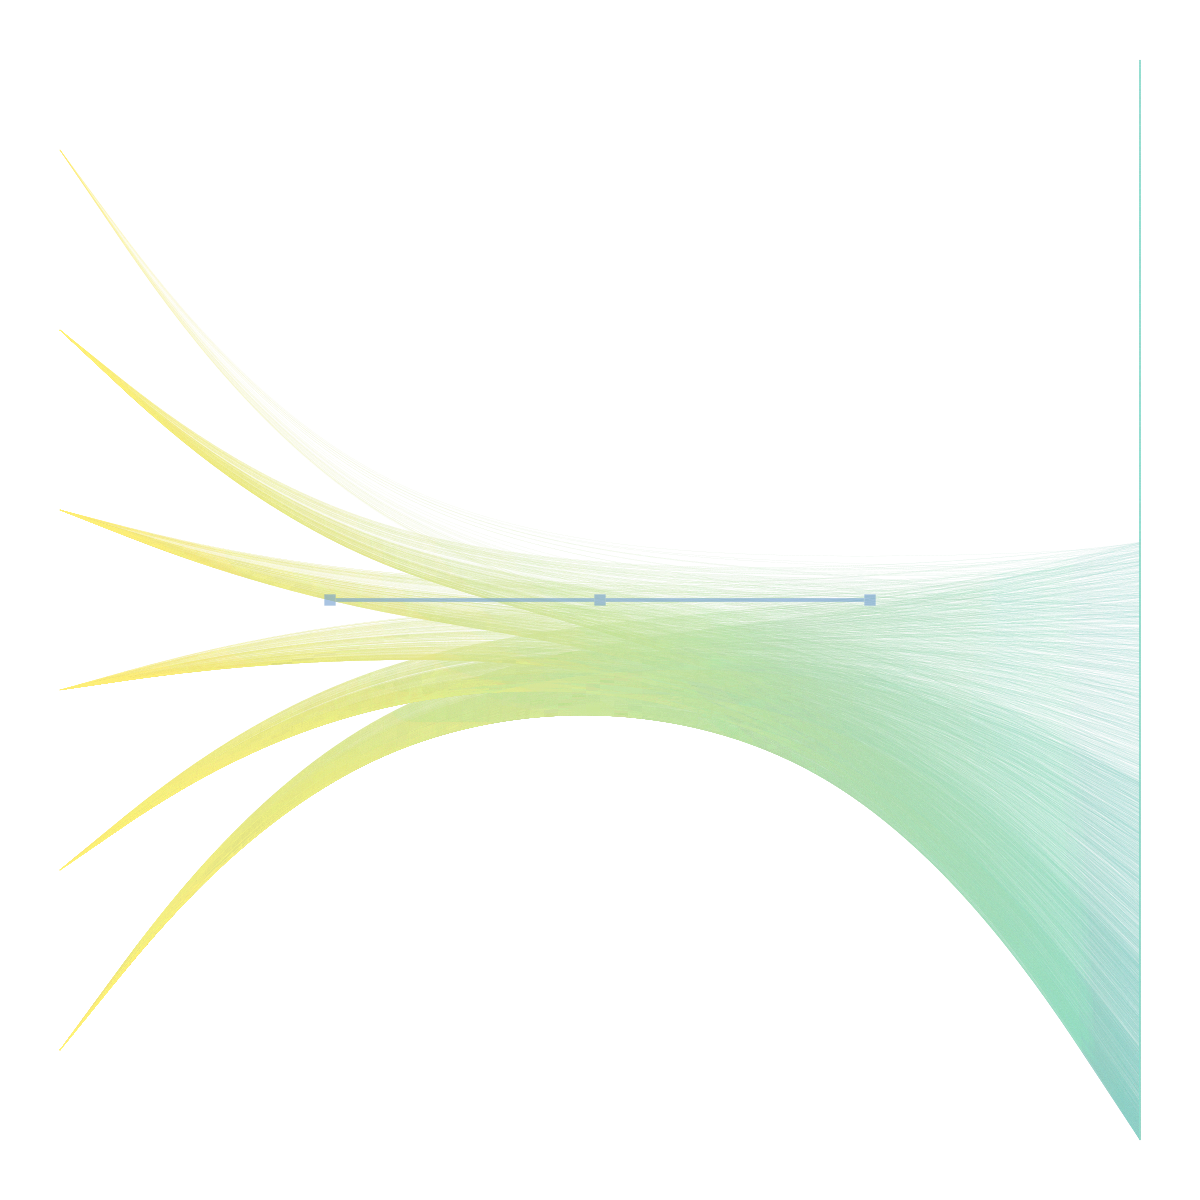

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f323ce3f730, at 0x7f323d0dc970>,
 <GraphView object, directed, with 38426 vertices and 38425 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f323d0dc2b0, at 0x7f323ce3f5e0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f323d0dc2b0, at 0x7f323d0dc490>, False), at 0x7f323d0dc2b0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f323d0dc2b0, at 0x7f326051be20>)

In [10]:
synth_model.draw(subsample_edges=6000,layout='bipartite',bip_aspect=1, hvertex_size=8, hedge_pen_width=1.9, output_size=(600, 600))

In [11]:
def index_array(which_model,clabel):
    array = [i for i in range(len(which_model.get_clabel(l=0).a)) if which_model.get_clabel(l=0).a[i] == clabel]
    return array

In [12]:
words_index = index_array(which_model=synth_model, clabel=1)
documents_index = index_array(which_model=synth_model, clabel=0)

synth_df = pd.DataFrame(data=0, index=documents_index, columns=words_index)

for document in documents_index:
    neighbors = nest_state.g.get_all_neighbors(document)
    if neighbors.size == 0:
        continue
    else:
        for col in synth_df.columns:
            if col in neighbors:
                synth_df[col][document] = 1

synth_df

,38417,38418,38419,38420,38421,38422
0,1,1,0,0,0,0
1,0,1,1,0,0,0
2,0,0,0,1,0,0
3,0,1,0,0,0,0
4,0,1,0,1,0,0
...,...,...,...,...,...,...
38412,0,0,0,0,0,0
38413,0,0,0,1,1,0
38414,0,0,0,0,1,0
38415,0,1,0,1,0,0


In [13]:
state = model.state
state_0 = state.get_levels()[0]
matrix = gt.adjacency(g=state_0.get_bg(),weight=state_0.get_ers()).T
graph = gt.generate_sbm(b=state_0.b.a, probs=matrix, 
                            out_degs=state_0.g.degree_property_map("total").a,
                            in_degs=state_0.g.degree_property_map("total").a,
                            directed=False)
new_state = gt.minimize_nested_blockmodel_dl(graph,
                                             state_args=dict(base_type=gt.BlockState, **{'clabel': state_0.g.vp['kind'], 'pclabel': state_0.g.vp['kind']}),
                                             multilevel_mcmc_args=dict(verbose=False))

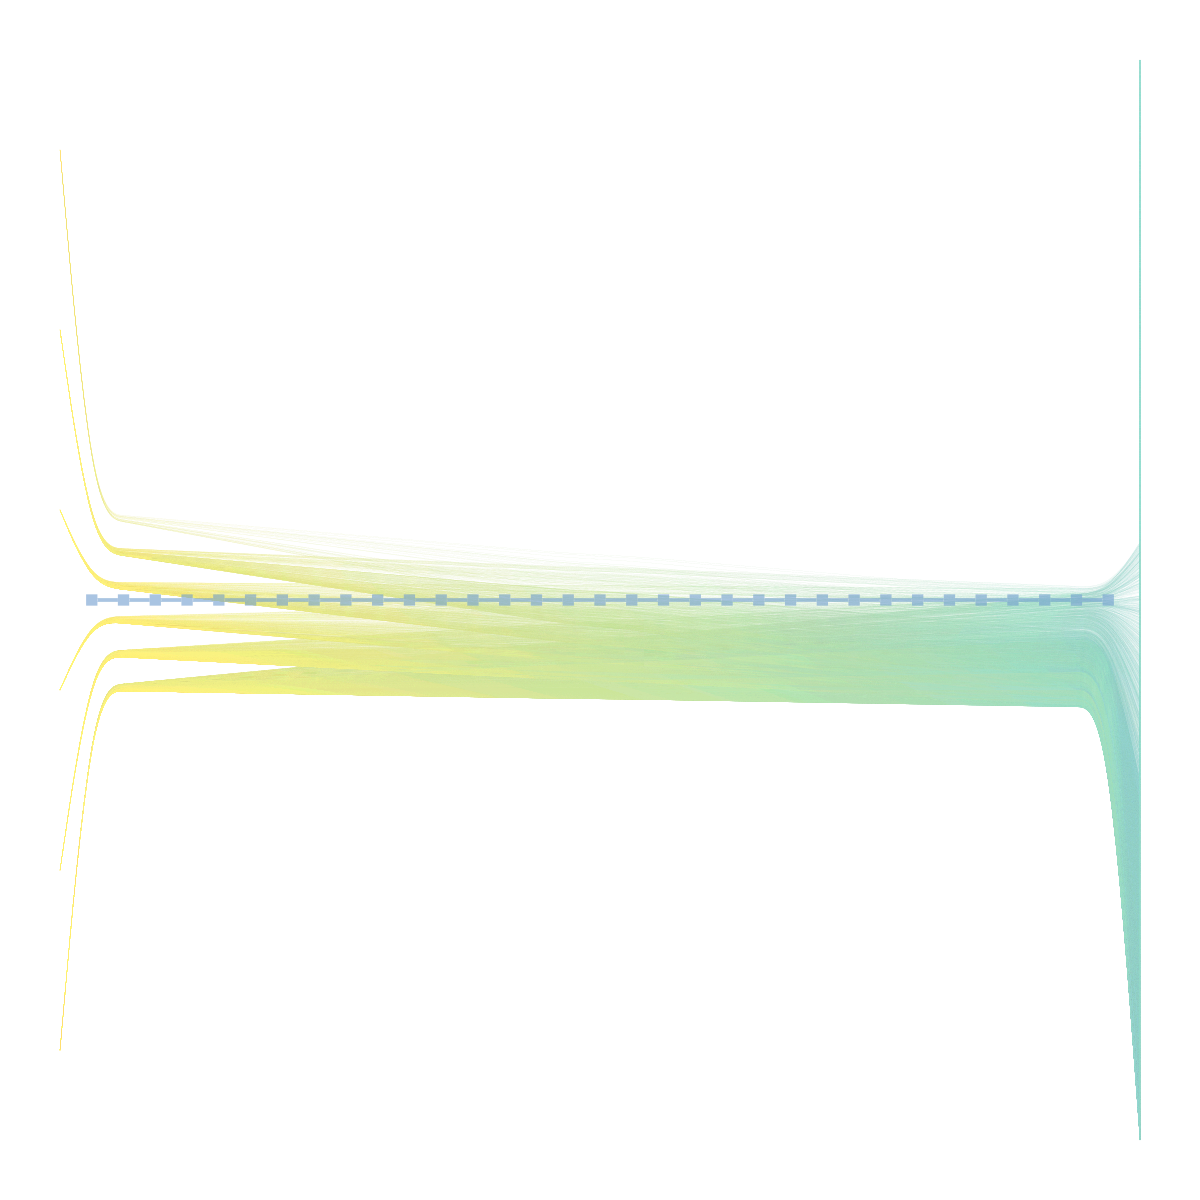

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f323ce4e220, at 0x7f323cff5fd0>,
 <GraphView object, directed, with 38456 vertices and 38455 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f323cfe6bb0, at 0x7f323d0e5700>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f323cfe6bb0, at 0x7f323cfe6700>, False), at 0x7f323cfe6bb0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f323cfe6bb0, at 0x7f323d0df850>)

In [14]:
new_state.draw(layout="bipartite",subsample_edges=6000,bip_aspect=1, hvertex_size=8, hedge_pen_width=1.9, output_size=(600, 600))

In [15]:
for i_n_init in range(10):
    base_type = gt.BlockState
    state_tmp = gt.minimize_nested_blockmodel_dl(graph,
                                                state_args=dict(
                                                    base_type=base_type,
                                                    **{'clabel': state_0.g.vp['kind'], 'pclabel': state_0.g.vp['kind']}),
                                                multilevel_mcmc_args=dict(
                                                    verbose=False))
    L = 0
    for s in state_tmp.levels:
        L += 1
        if s.get_nonempty_B() == 2:
            break
    state_tmp = state_tmp.copy(bs=state_tmp.get_bs()[:L] + [np.zeros(1)])

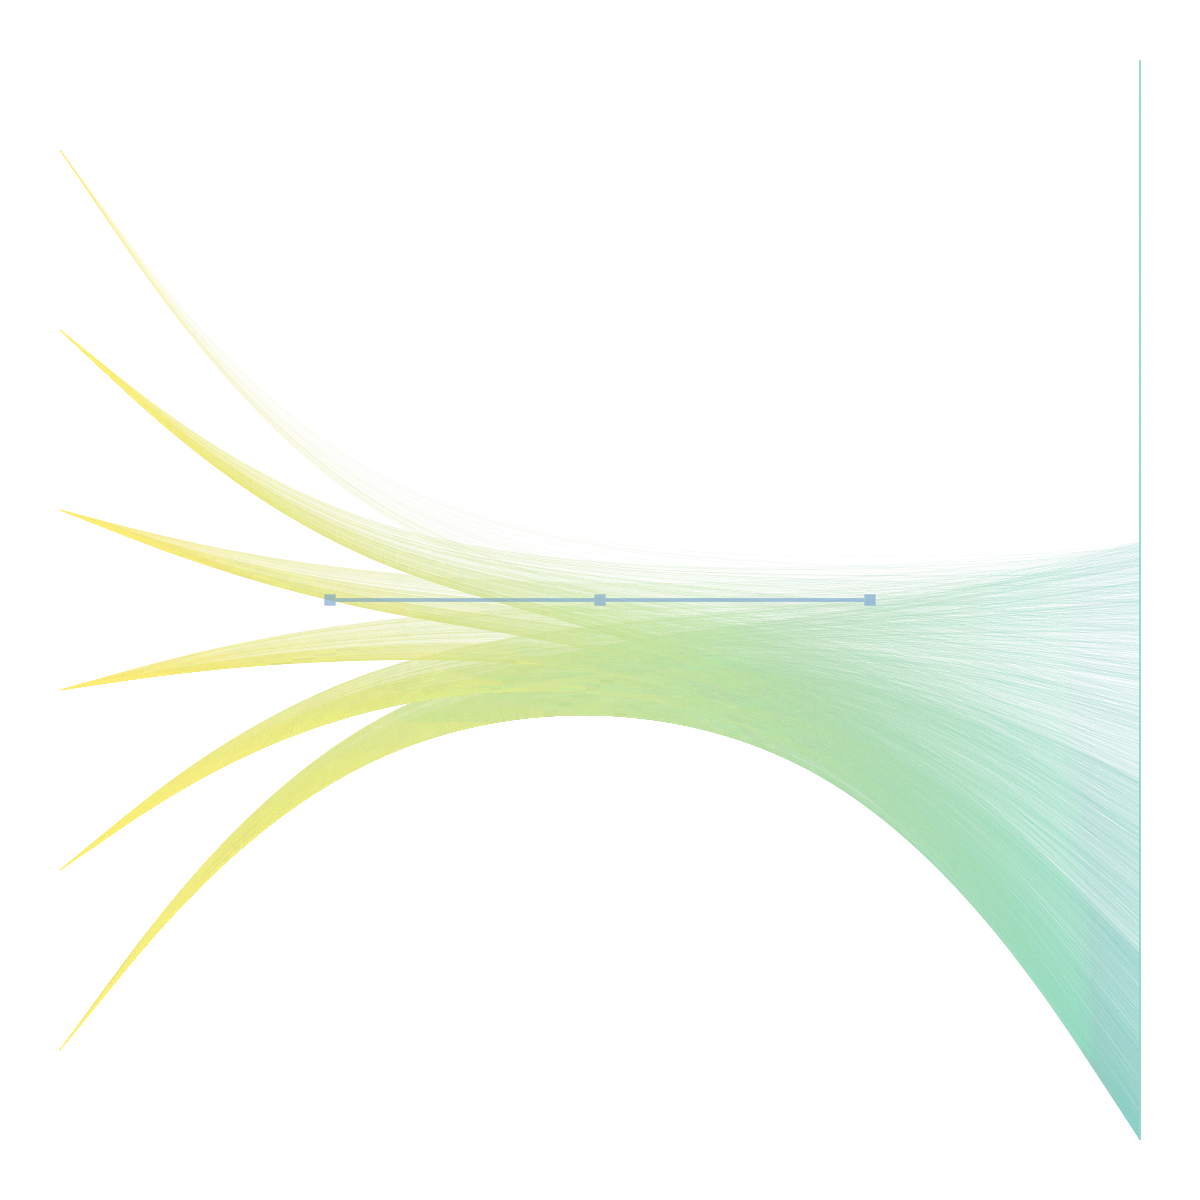

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f323ce4e220, at 0x7f323d0116d0>,
 <GraphView object, directed, with 38426 vertices and 38425 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f31fb9dd220, at 0x7f323d01b9a0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f31fb9dd220, at 0x7f323d01b610>, False), at 0x7f31fb9dd220>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f31fb9dd220, at 0x7f323d01c460>)

In [16]:
state_tmp.draw(layout="bipartite",subsample_edges=6000,bip_aspect=1, hvertex_size=8, hedge_pen_width=1.9, output_size=(600, 600))

In [17]:
features_index = index_array(which_model=state_tmp, clabel=1)
patients_index = index_array(which_model=state_tmp, clabel=0)

df = pd.DataFrame(data=0, index=patients_index, columns=features_index)

for patient in patients_index:
    neighbors = state_tmp.g.get_all_neighbors(patient)
    if neighbors.size == 0:
        continue
    else:
        for col in df.columns:
            if col in neighbors:
                df[col][patient] = 1

df

,38417,38418,38419,38420,38421,38422
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,1,0,0,0,0,0
3,0,1,0,0,0,0
4,0,1,1,0,0,0
...,...,...,...,...,...,...
38412,0,0,0,0,0,0
38413,0,1,1,0,0,0
38414,0,0,0,0,0,0
38415,0,1,0,1,0,0


In [18]:
df.describe()

,38417,38418,38419,38420,38421,38422
count,38417.000000,38417.000000,38417.000000,38417.000000,38417.000000,38417.000000
mean,0.106333,0.360413,0.085952,0.262332,0.099071,0.008304
std,0.308268,0.480127,0.280296,0.439908,0.298761,0.090746
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
for v in model.state.g.vertices():
    if state.g.vp['kind'][v]==1:
        print('name: %s , index: %d' % (state.g.vp['name'][v], v))

name: renal_failure , index: 38417
name: hypertension , index: 38418
name: liver_disease , index: 38419
name: cardiac_arrhythmias , index: 38420
name: valvular_disease , index: 38421
name: peptic_ulcer , index: 38422


In [20]:
df = df.rename(columns={38417: "renal_failure", 38418: "hypertension", 38419: "liver_disease", 38420: "cardiac_arrhythmias", 
                   38421: "valvular_disease", 38422: "peptic_ulcer"})

In [21]:
df.to_csv("synthetic_simple_elixhauser_comorbidity.csv",index=False)

/home/viren/Dissertation/sbmtm.py:571: RuntimeWarning: invalid value encountered in true_divide
  p_td_d = (n_db/np.sum(n_db,axis=1)[:,np.newaxis]).T
/home/viren/Dissertation/sbmtm.py:577: RuntimeWarning: invalid value encountered in true_divide
  p_tw_d = (n_dbw/np.sum(n_dbw,axis=1)[:,np.newaxis]).T


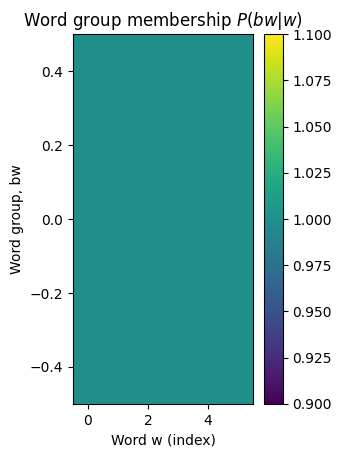

In [22]:
p_td_d,p_tw_w = model.group_membership(l=0)

plt.subplot(122)
plt.imshow(p_tw_w,origin='lower',aspect='auto',interpolation='none')
plt.title(r'Word group membership $P(bw | w)$')
plt.xlabel('Word w (index)')
plt.ylabel('Word group, bw')
plt.colorbar()


In [23]:
features_index = index_array(which_model=state, clabel=1)
patients_index = index_array(which_model=state, clabel=0)

df_org = pd.DataFrame(data=0, index=patients_index, columns=features_index)

for patient in patients_index:
    neighbors = state.g.get_all_neighbors(patient)
    if neighbors.size == 0:
        continue
    else:
        for col in df_org.columns:
            if col in neighbors:
                df_org[col][patient] = 1

df_org

,38417,38418,38419,38420,38421,38422
0,1,1,0,0,0,0
1,0,1,1,0,0,0
2,0,0,0,1,0,0
3,0,1,0,0,0,0
4,0,1,0,1,0,0
...,...,...,...,...,...,...
38412,0,0,0,0,0,0
38413,0,0,0,1,1,0
38414,0,0,0,0,1,0
38415,0,1,0,1,0,0


In [24]:
df_org.describe()

,38417,38418,38419,38420,38421,38422
count,38417.000000,38417.000000,38417.000000,38417.000000,38417.000000,38417.000000
mean,0.120650,0.533097,0.090273,0.340058,0.109795,0.008226
std,0.325724,0.498910,0.286576,0.473734,0.312638,0.090322
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
print(gt.vertex_average(state.g, "total"))
print(gt.vertex_average(state_tmp.g, "total"))

(2.4038206282695262, 0.659118143072608)
(2.40782864430159, 0.6618665476041458)


In [26]:
# edge overlap
overlap = 0
for e in state.g.edges():
    if state_tmp.g.edge(e.source(), e.target()):
        overlap += 1
overlap

18422

In [27]:
# similarity
gt.similarity(state.g, state_tmp.g)

0.3985763584634191

In [28]:
df_org = df_org.rename(columns={38417: "renal_failure", 38418: "hypertension", 38419: "liver_disease", 38420: "cardiac_arrhythmias", 
                   38421: "valvular_disease", 38422: "peptic_ulcer"})

In [29]:
list(df_org)

['renal_failure',
 'hypertension',
 'liver_disease',
 'cardiac_arrhythmias',
 'valvular_disease',
 'peptic_ulcer']

In [41]:
# Hamming Distance
distance = []
for disease in list(df_org):
    d = np.sum(df_org[disease].to_list() != df[disease].to_list())
    distance.append(d)

# Calculate the average distance
distance = np.mean(distance)

# Print the result
print(f"Hamming distance: {distance:.2f}")

Hamming distance: 1.00


In [37]:
# Jaccard index
similarity = []
for disease in list(df_org):
    s = np.intersect1d(df_org[disease].to_list(), df[disease].to_list()).size / np.union1d(df_org[disease].to_list(),df[disease].to_list()).size
    similarity.append(s)

# Calculate the overall similarity
similarity = np.mean(similarity)

# Print the result
print(f"Jaccard similarity: {similarity:.2f}")

Jaccard similarity: 1.00


In [36]:
from sklearn.metrics import jaccard_score

similarity = []
for disease in list(df_org):
    s = jaccard_score(df_org[disease].to_list(), df[disease].to_list())
    similarity.append(s)


# Calculate the overall similarity
similarity = np.mean(similarity)

# Print the result
print(f"Jaccard similarity: {similarity:.2f}")


Jaccard similarity: 0.18


In [33]:
# Chi-squared test


In [34]:
import matplotlib.pyplot as plt 

list(df_org.columns)
df.sum(axis=0)

renal_failure           4085
hypertension           13846
liver_disease           3302
cardiac_arrhythmias    10078
valvular_disease        3806
peptic_ulcer             319
dtype: int64